<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2 Assignment 2*

# Document Representations: Bag-Of-Words

In [41]:
import re
import string
from collections import Counter

# !pip install --user nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_sm")
STOP_WORDS = nlp.Defaults.stop_words.union(['\n'])

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import squarify

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to /home/joseph/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/joseph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
df = pd.read_csv('./job_listings.csv', index_col=0)
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [4]:
df['description'][0]

'b"<div><div>Job Requirements:</div><ul><li><p>\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\\n</li><li><p>Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><d

In [20]:
# First: clean the description text by removing HTML tags
import string

def remove_tags(docs):
    clean_text = []
    for text in docs:
        soup = BeautifulSoup(text)
        text = soup.text.strip("b'")
        text = text.replace('\\n', ' ')
        clean_text.append(text)
    return clean_text

print(remove_tags(df['description'][:1]))

['"Job Requirements: Conceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role) Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R Ability to communicate Model findings to both Technical and Non-Technical stake holders Hands on experience in SQL/Hive or similar programming language Must show past work via GitHub, Kaggle or any other published article Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field. Apply Now"']


In [21]:
df['clean_desc'] = remove_tags(df['description'])
df.head()

,description,title,tokens,lemmas,clean_desc
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"(b""<div><div>Job, Requirements:</div><ul><li><...","[b""<div><div, Job, requirements:</div><ul><li>...","""Job Requirements: Conceptual understanding in..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"(b'<div>Job, Description<br/>\n<br/>\n<p>As, a...","[b'<div, Job, Description, br/>\n, br/>\n, p, ...","Job Description As a Data Scientist 1, you wi..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,"(b'<div><p>As, a, Data, Scientist, you, will, ...","[b'<div><p, as, Data, Scientist, work, consult...",As a Data Scientist you will be working on con...
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"(b'<div, class=""jobsearch-JobMetadataHeader, i...","[b'<div, class=""jobsearch, JobMetadataHeader, ...","$4,969 - $6,756 a monthContractUnder the gener..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,"(b'<ul><li>Location:, USA, \xe2\x80\x93, multi...","[b'<ul><li, location, USA, \xe2\x80\x93, multi...",Location: USA \xe2\x80\x93 multiple locations ...


In [23]:
tokenizer = Tokenizer(nlp.vocab)

all_tokens = []

def tokenize(docs):
    tokenizer = Tokenizer(nlp.vocab)
    for text in docs:
        tokens = tokenizer(text)
        all_tokens.append(tokens)
    return all_tokens
        

df['tokens'] = tokenize(list(df['clean_desc']))
df.head()

,description,title,tokens,lemmas,clean_desc
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"(""Job, Requirements:, Conceptual, understandin...","[b""<div><div, Job, requirements:</div><ul><li>...","""Job Requirements: Conceptual understanding in..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"(Job, Description, , As, a, Data, Scientist, ...","[b'<div, Job, Description, br/>\n, br/>\n, p, ...","Job Description As a Data Scientist 1, you wi..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,"(As, a, Data, Scientist, you, will, be, workin...","[b'<div><p, as, Data, Scientist, work, consult...",As a Data Scientist you will be working on con...
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"($4,969, -, $6,756, a, monthContractUnder, the...","[b'<div, class=""jobsearch, JobMetadataHeader, ...","$4,969 - $6,756 a monthContractUnder the gener..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,"(Location:, USA, \xe2\x80\x93, multiple, locat...","[b'<ul><li, location, USA, \xe2\x80\x93, multi...",Location: USA \xe2\x80\x93 multiple locations ...


In [25]:
def lemmatize(docs):
    """
    Given a list of docs return a list of lemmatized tokens for each document.

    Parameters:
    ----------------
    docs (list): list of docs, could be a DataFrame column

    Returns:
    ----------------
    lemmas (list): 2-D list of lemmatized tokens per doc
    """
    
    
    lemmas = []
    for text in docs:
        doc = nlp(text)
        lemma = [token.lemma_.lower() for token in doc if (token.is_stop == False)\
                 and (token.is_punct != True)\
                 and (token.lemma_ != '-PRON-')]

        lemmas.append(lemma)
    
    return lemmas

df['lemmas'] = lemmatize(list(df['clean_desc']))
df.head()

,description,title,tokens,lemmas,clean_desc
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"(""Job, Requirements:, Conceptual, understandin...","[job, requirements, conceptual, understanding,...","""Job Requirements: Conceptual understanding in..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"(Job, Description, , As, a, Data, Scientist, ...","[job, description, , data, scientist, 1, help...","Job Description As a Data Scientist 1, you wi..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,"(As, a, Data, Scientist, you, will, be, workin...","[data, scientist, work, consult, business, res...",As a Data Scientist you will be working on con...
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"($4,969, -, $6,756, a, monthContractUnder, the...","[$, 4,969, $, 6,756, monthcontractunder, gener...","$4,969 - $6,756 a monthContractUnder the gener..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,"(Location:, USA, \xe2\x80\x93, multiple, locat...","[location, usa, \xe2\x80\x93, multiple, locati...",Location: USA \xe2\x80\x93 multiple locations ...


# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [27]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(df['clean_desc'])

# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.
vectorizer.vocabulary_

# The vocabulary dictionary does not represent the counts of words.
dtm = vectorizer.transform(df['clean_desc'])
dtm = pd.DataFrame(dtm.todense(), columns=vectorizer.get_feature_names())
dtm.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
dtm.describe()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,...,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,0.004695,0.122066,0.002347,0.004695,0.002347,0.002347,0.009390,0.002347,0.004695,0.002347,...,0.004695,0.009390,0.037559,0.002347,0.023474,0.004695,0.002347,0.002347,0.004695,0.014085
std,0.068438,0.489063,0.048450,0.068438,0.048450,0.048450,0.096558,0.048450,0.068438,0.048450,...,0.068438,0.193801,0.547506,0.048450,0.484502,0.068438,0.048450,0.048450,0.096900,0.290701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,4.000000,8.000000,1.000000,10.000000,1.000000,1.000000,1.000000,2.000000,6.000000


# 4) Visualize the most common word counts

In [30]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = list(zip(word_counts.keys(), word_counts.values()))
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = list(zip(appears_in.keys(), appears_in.values()))
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

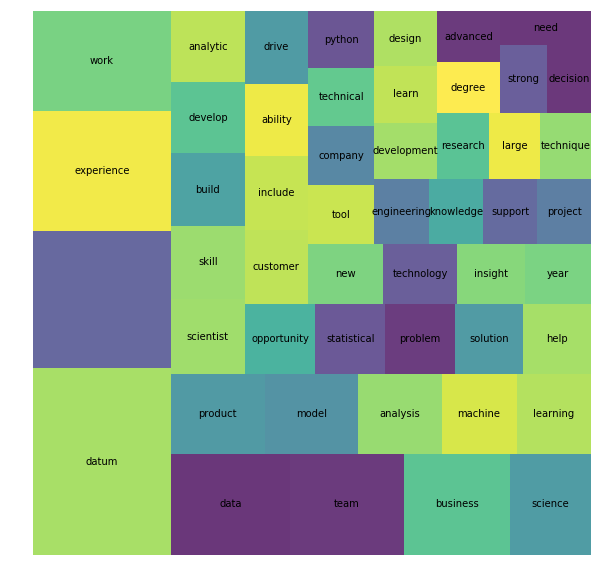

In [38]:
wc = count(df['lemmas'])
wc_top20 = wc[wc['rank'] <= 50]
plt.figure(figsize=(10,10))
squarify.plot(sizes=wc_top20['pct_total'],
              label=wc_top20['word'],
              alpha=0.8)
plt.axis('off')

plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [66]:
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['clean_desc'])

dtm_df = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm_df.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.106253,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


 # 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [61]:
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
# Fit on TF-IDF Vectors
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [76]:
query = tfidf.transform(["Big data engineering role involving Apache Hadoop, Spark, HDFS, Luigi, Docker, kafka, and devops."])
nn.kneighbors(query.todense())

(array([[1.24918425, 1.24918425, 1.29492633, 1.29492633, 1.3336686 ]]),
 array([[ 42, 138,  80, 202, 354]]))

In [80]:
print(dtm_df.loc[42].sort_values(ascending=False)[:20])

conceptshave         0.404125
pythonstronger       0.202062
miningprogramming    0.202062
hdfs                 0.192306
understanding        0.189627
null                 0.184738
learning             0.178655
kept                 0.168799
hadoop               0.168351
guidelines           0.164805
confidential         0.164805
fine                 0.164805
language             0.155059
apache               0.152334
kafka                0.152334
image                0.149820
according            0.149820
machine              0.145770
information          0.132732
specifically         0.130157
Name: 42, dtype: float64


## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.